In [1]:
%matplotlib inline

In [2]:
import yaml
import logging
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from typing import List, Optional
from multiprocessing.pool import Pool
from multiprocessing import Queue, Manager

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

In [4]:
def mk_job_id(router_type, seed):
    return '{}:{}'.format(router_type, seed)

def un_job_id(job_id):
    [router_type, s_seed] = job_id.split(':')
    return router_type, int(s_seed)

def add_avg(df: pd.DataFrame):
    df['avg'] = df['sum'] / df['count']
    return df

def plot_data(figsize=(15,5), xlim=None, ylim=None, target='avg', **dfs):
    fig = plt.figure(figsize=figsize)
    handles = []
    min_target = 'min_' + target
    max_target = 'max_' + target
    
    for (label, df) in dfs.items():
        if min_target in df.columns:
            # this is combined data, draw errorbar
            minerr = df[target] - df[min_target]
            maxerr = df[max_target] - df[target]
            line = plt.errorbar(df['time'], df[target],
                                yerr=[minerr, maxerr], label=label)
        else:
            line, = plt.plot(df['time'], df[target], label=label)
        handles.append(line)
        
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
        
    plt.legend(handles=handles)
    plt.show()

def split_data(dct):
    results = []
    
    def add_res(i, key, val):
        while len(results) <= i:
            results.append({})
        results[i][key] = val
    
    for (key, vals) in dct.items():
        for (i, val) in enumerate(vals):
            add_res(i, key, val)
    return tuple(results)
    
def combine_launch_data(launch_data, target='avg'):
    data_unwrapped = {}
    for (job_id, data) in launch_data.items():
        router_type, seed = un_job_id(job_id)
        if router_type not in data_unwrapped:
            data_unwrapped[router_type] = []
        data_unwrapped[router_type].append(data)
    
    result_data = {}
    min_target = 'min_' + target
    max_target = 'max_' + target
    for (router_type, runs) in data_unwrapped.items():
        df = runs[0].copy()
        df[min_target] = df[target]
        df[max_target] = df[target]
        for run in runs[1:]:
            df['sum'] += run['sum']
            df['count'] += run['count']
            df[min_target] = df[min_target].combine(run[target], min)
            df[max_target] = df[max_target].combine(run[target], max)
            
        # averaging all meaningfull data across runs
        df = add_avg(df)
        df['sum'] /= len(runs) 
        df['count'] /= len(runs)
        
        result_data[router_type] = df
        
    return result_data

In [5]:
class DummyTqdmFile(object):
    """Dummy file-like that will write to tqdm"""
    file = None
    def __init__(self, file):
        self.file = file

    def write(self, x):
        # Avoid print() second call (useless \n)
        if len(x.rstrip()) > 0:
            tqdm.write(x, file=self.file)

    def flush(self):
        return getattr(self.file, "flush", lambda: None)()

@contextlib.contextmanager
def std_out_err_redirect_tqdm():
    orig_out_err = sys.stdout, sys.stderr
    try:
        sys.stdout, sys.stderr = map(DummyTqdmFile, orig_out_err)
        yield orig_out_err[0]
    # Relay exceptions
    except Exception as exc:
        raise exc
    # Always restore sys.stdout/err if necessary
    finally:
        sys.stdout, sys.stderr = orig_out_err

In [6]:
class DummyProgressbarQueue:
    def __init__(self, bar):
        self.bar = bar
        
    def put(self, val):
        _, _, delta = val
        if delta is not None:
            self.bar.update(delta)

In [7]:
def run_network_scenario_file(file: str, router_type: str, random_seed: int = None,
                              progress_step: Optional[int] = None, progress_queue: Optional[Queue] = None,
                              series_period: int = 500,
                              series_funcs: List[str] = ['count', 'sum', 'min', 'max']):
    """
    Helper wrapper around `run_network_scenario` which should run in a separate thread.
    """
    
    # Importing here because of problemes with Tensorflow in multiple threads
    from dqnroute import event_series, run_network_scenario, DQNROUTE_LOGGER, TF_MODELS_DIR

    logger = logging.getLogger(DQNROUTE_LOGGER)
    TF_MODELS_DIR = '../tf_models'
    #logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
    
    with open(file) as f:
        run_params = yaml.safe_load(f)
    
    series = event_series(series_period, series_funcs)
    series = run_network_scenario(run_params, router_type, series, random_seed=random_seed,
                                  progress_step=progress_step, progress_queue=progress_queue)
    return add_avg(series.getSeries())

def run_conveyor_scenario_file(file: str, router_type: str, random_seed: int = None,
                               progress_step: Optional[int] = None, progress_queue: Optional[Queue] = None,
                               series_period: int = 500,
                               series_funcs: List[str] = ['count', 'sum', 'min', 'max']):
    """
    Helper wrapper around `run_conveyor_scenario` which should run in a separate thread.
    """
    
    from dqnroute import event_series, run_conveyor_scenario, DQNROUTE_LOGGER, TF_MODELS_DIR

    logger = logging.getLogger(DQNROUTE_LOGGER)
    TF_MODELS_DIR = '../tf_models'
    #logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
    
    with open(file) as f:
        run_params = yaml.safe_load(f)
    
    time_series = event_series(series_period, series_funcs)
    energy_series = event_series(series_period, series_funcs)
    
    time_series, energy_series = \
        run_conveyor_scenario(run_params, router_type, time_series, energy_series,
                              random_seed=random_seed,
                              progress_step=progress_step, progress_queue=progress_queue)
    
    return add_avg(time_series.getSeries()), add_avg(energy_series.getSeries())

def run_threaded(func, router_types: List[str], random_seeds: List[int], *args, **kwargs):
    """
    Runs several scenario runners in multiple threads and displays progress bars for them
    """

    pool = Pool()
    m = Manager()
    queue = m.Queue()
    jobs = {}
    bars = {}
    for router_type in router_types:
        for seed in random_seeds:
            job_id = mk_job_id(router_type, seed)
            job_args = dict(kwargs, router_type=router_type, random_seed=seed,
                            progress_queue=queue)
            jobs[job_id] = pool.apply_async(func, args=args, kwds=job_args,
                                            error_callback=print)
            bars[job_id] = tqdm_notebook(desc=job_id)

    # TODO: fix progressbars somehow
    while len(bars) > 0:
        (rt, s, val) = queue.get()
        job_id = mk_job_id(rt, s)
        if val is None:
            bars.pop(job_id).close()
        else:
            bars[job_id].update(val)
        
    results = {job_id: job.get() for (job_id, job) in jobs.items()}
    
    if type(next(iter(results.values()))) is tuple:
        return split_data(results)
    return results

In [8]:
launch6_data_mult = run_threaded(run_network_scenario_file, random_seeds=[42, 43, 44],
                                 file='../launches/launch6.yaml', router_types=['simple_q', 'link_state', 'dqn'],
                                 progress_step=500)

/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_mode

In [9]:
launch6_data_comb = combine_launch_data(launch6_data_mult)

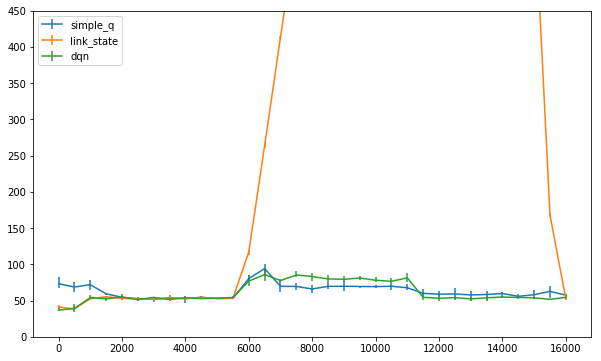

In [10]:
plot_data(figsize=(10,6), ylim=(0,450), **launch6_data_comb)

In [17]:
launch8_data = run_threaded(run_network_scenario_file, file='../launches/launch8.yaml',
                            router_types=['simple_q', 'link_state', 'dqn'], progress_step=500,
                            random_seeds=[42, 43, 44])

launch8_data_comb = combine_launch_data(launch8_data)

/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_mode

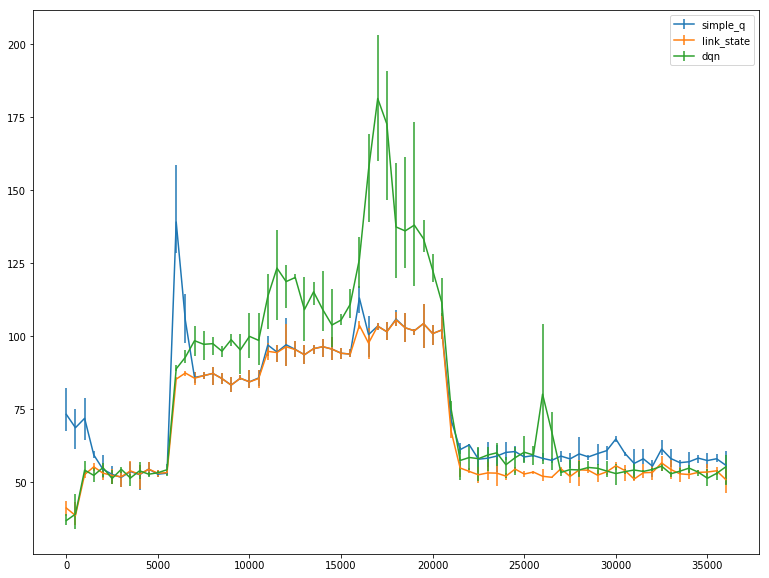

In [19]:
plot_data(figsize=(13,10), **launch8_data_comb)

In [20]:
conveyor_data_full = run_threaded(run_conveyor_scenario_file, file='../launches/conveyor_energy_test.yaml',
                                  router_types=['simple_q', 'link_state', 'dqn'], progress_step=500,
                                  random_seeds=[42, 43, 44])

/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.WARNING:tensorflow:From /home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restori

In [21]:
conveyor_data_time, conveyor_data_nrg = conveyor_data_full

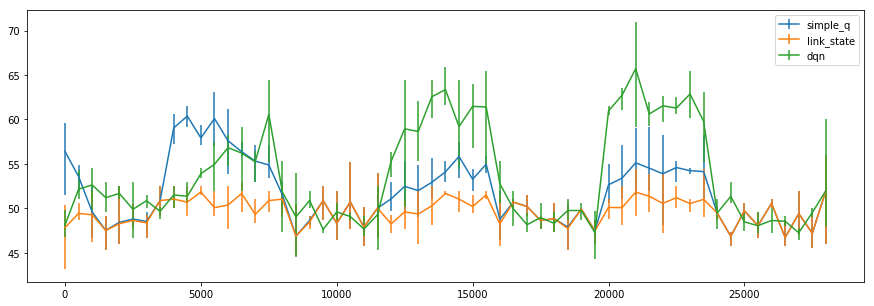

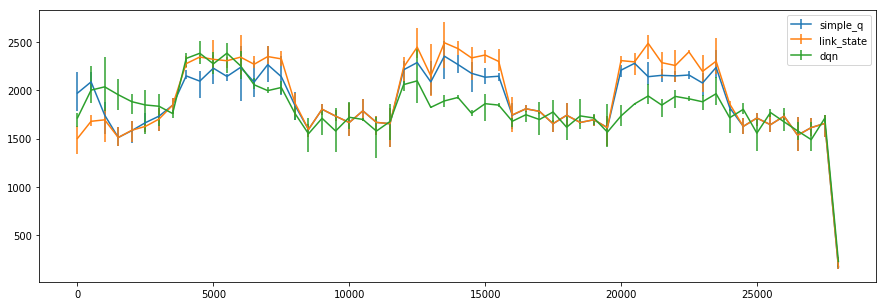

In [22]:
conveyor_data_time_comb = combine_launch_data(conveyor_data_time)
conveyor_data_nrg_comb = combine_launch_data(conveyor_data_nrg, target='sum')

plot_data(**conveyor_data_time_comb)
plot_data(**conveyor_data_nrg_comb, target='sum')

In [ ]:
conveyor2_data_full = run_threaded(run_conveyor_scenario_file, file='../launches/conveyor_energy_test_2.yaml',
                                   router_types=['link_state', 'simple_q', 'dqn'], progress_step=500,
                                   random_seeds=[42, 43, 44])

/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
/home/flyingleafe/Research/dqnroute/pythonenv/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.10.3 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/d

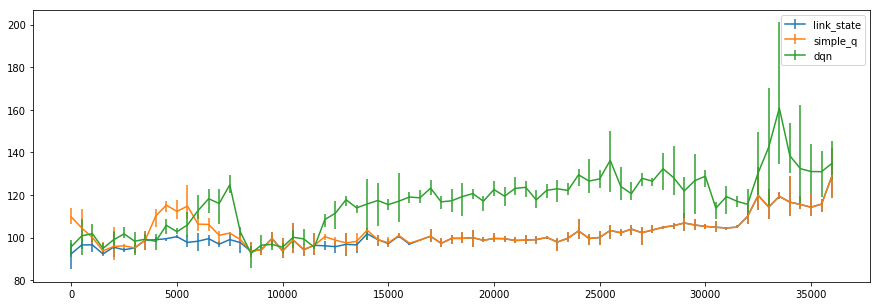

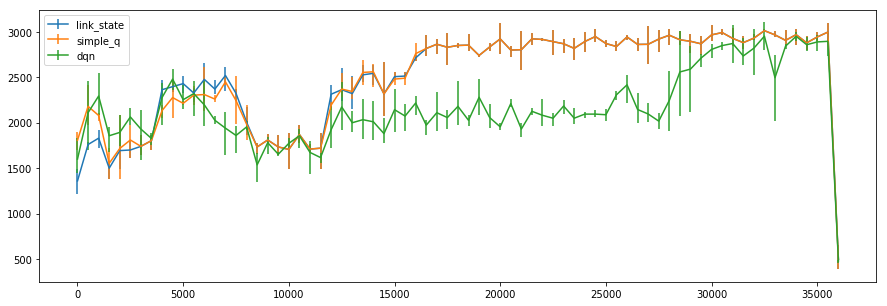

In [22]:
conveyor2_data_time, conveyor2_data_nrg = conveyor2_data_full
conveyor2_data_time_comb = combine_launch_data(conveyor2_data_time)
conveyor2_data_nrg_comb = combine_launch_data(conveyor2_data_nrg, target='sum')

plot_data(**conveyor2_data_time_comb)
plot_data(**conveyor2_data_nrg_comb, target='sum')